In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import lightgbm as lgb

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_cols = list(train_df.columns)
test_cols = list(test_df.columns)
train_cols.remove('fiberID')
test_cols.remove('fiberID')

## DATA Setting

In [6]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [7]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    (추가옵션)각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [8]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

train_df.shape, test_df.shape

((199991, 63), (10009, 61))

### PCA

In [9]:
from sklearn.decomposition import PCA
pca = PCA(1)

In [10]:
ori_name = ["psfMag","fiberMag","petroMag","modelMag"]
add_name = ["u","g","r","i","z"]

In [11]:
for add in add_name:
    selected = list(map(lambda x : x+"_"+add,ori_name))
    train_df['PCA_'+add] = pca.fit_transform(train_df[selected])
    test_df['PCA_'+add] = pca.fit_transform(test_df[selected])

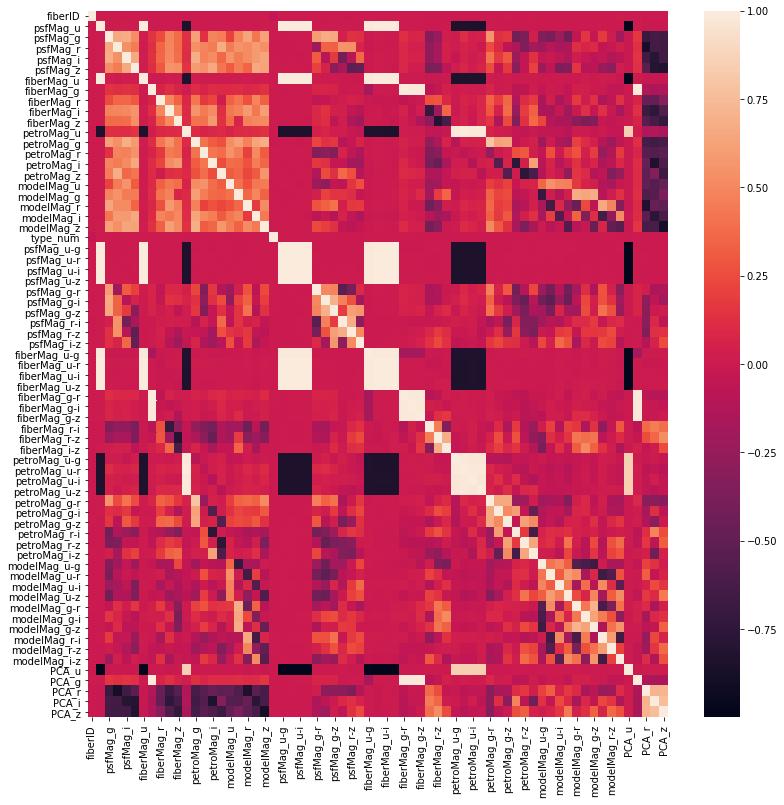

In [34]:
plt.figure(figsize=(13,13))
sns.heatmap(train_df.corr())

In [13]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'type_num', 'psfMag_u-g', 'psfMag_u-r', 'psfMag_u-i',
       'psfMag_u-z', 'psfMag_g-r', 'psfMag_g-i', 'psfMag_g-z', 'psfMag_r-i',
       'psfMag_r-z', 'psfMag_i-z', 'fiberMag_u-g', 'fiberMag_u-r',
       'fiberMag_u-i', 'fiberMag_u-z', 'fiberMag_g-r', 'fiberMag_g-i',
       'fiberMag_g-z', 'fiberMag_r-i', 'fiberMag_r-z', 'fiberMag_i-z',
       'petroMag_u-g', 'petroMag_u-r', 'petroMag_u-i', 'petroMag_u-z',
       'petroMag_g-r', 'petroMag_g-i', 'petroMag_g-z', 'petroMag_r-i',
       'petroMag_r-z', 'petroMag_i-z', 'modelMag_u-g', 'modelMag_u-r',
       'modelMag_u-i', 'modelMag_u-z', 'modelMag_g-r', 'modelMag_g-i',
       'modelMag_g-z', 'modelMag_r-i', 'modelMag_r-z

In [14]:
train_X= train_df.drop(['type','type_num'],axis = 1)
test_X = test_df
train_y = train_df['type_num']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

### modeling

In [16]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 127, min_child_samples = 50,
                            max_depth = 8, learning_rate = 0.01,
                            lambda_l2 = 7, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [17]:
lgbm_c.fit(X_train, y_train, eval_set = [(X_train,y_train),(X_test, y_test)],eval_names= ['train','valid'], 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.909735	valid's multi_logloss: 0.926425
[200]	train's multi_logloss: 0.570275	valid's multi_logloss: 0.594457
[300]	train's multi_logloss: 0.438953	valid's multi_logloss: 0.468611
[400]	train's multi_logloss: 0.380766	valid's multi_logloss: 0.415155
[500]	train's multi_logloss: 0.34961	valid's multi_logloss: 0.388958
[600]	train's multi_logloss: 0.330285	valid's multi_logloss: 0.374801
[700]	train's multi_logloss: 0.317107	valid's multi_logloss: 0.36673
[800]	train's multi_logloss: 0.307238	valid's multi_logloss: 0.361679
[900]	train's multi_logloss: 0.298895	valid's multi_logloss: 0.358066
[1000]	train's multi_logloss: 0.29127	valid's multi_logloss: 0.355543
[1100]	train's multi_logloss: 0.284541	valid's multi_logloss: 0.353703
[1200]	train's multi_logloss: 0.278278	valid's multi_logloss: 0.352308
[1300]	train's multi_logloss: 0.272276	valid's multi_logloss: 0.351313
[1400]	train's multi_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=9, lambda_l2=7,
               learning_rate=0.01, max_depth=8, min_child_samples=50,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=127, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [18]:
train_y_pred = lgbm_c.predict_proba(X_test)

from sklearn.metrics import log_loss
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3477312805263439

In [19]:
train_y_pred

array([[3.09657953e-04, 5.77377345e-05, 2.12048646e-05, ...,
        2.54878141e-05, 4.02406164e-05, 2.15471053e-02],
       [1.89453207e-05, 4.11413419e-05, 2.42728160e-05, ...,
        5.79503018e-05, 1.85940242e-05, 2.43031099e-05],
       [1.72712904e-03, 6.51634321e-04, 1.26097780e-04, ...,
        1.59474655e-04, 3.36976809e-04, 1.14828166e-03],
       ...,
       [2.56001204e-03, 2.45790548e-03, 8.03336194e-05, ...,
        9.15603964e-05, 1.25214651e-04, 5.96345687e-01],
       [1.03508654e-05, 2.11897019e-05, 5.79613350e-06, ...,
        7.07611382e-06, 6.14701264e-06, 3.92279364e-04],
       [2.62462761e-04, 1.49134852e-04, 8.41347910e-05, ...,
        8.88033403e-05, 6.01651462e-04, 3.31920121e-04]])

In [20]:
test_y_pred = lgbm_c.predict_proba(test_X)

In [21]:
test_y_pred

array([[1.93667409e-04, 3.33060210e-04, 2.30075400e-03, ...,
        8.63201554e-04, 1.83075293e-03, 2.39584223e-04],
       [5.17953166e-04, 4.13340723e-04, 1.34320810e-04, ...,
        1.90729088e-04, 5.19001101e-03, 6.81312806e-04],
       [8.73042884e-05, 2.07017541e-05, 9.07792099e-06, ...,
        9.66792361e-06, 4.69908093e-05, 3.61819197e-05],
       ...,
       [7.59110617e-06, 8.16827646e-06, 1.29089783e-06, ...,
        2.91916087e-06, 1.65148622e-06, 6.53183205e-04],
       [1.10488935e-05, 2.64368156e-05, 2.26117655e-06, ...,
        4.00235798e-06, 2.59444189e-06, 7.04792727e-04],
       [5.12641063e-04, 1.56828656e-05, 8.06670924e-06, ...,
        1.99593625e-05, 1.22862783e-05, 4.86963629e-05]])

### feature_importance

In [22]:
pi_df = pd.DataFrame(lgbm_c.feature_importances_, index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df

,importance
fiberID,93313
psfMag_i-z,36153
modelMag_i-z,34465
petroMag_i-z,34102
fiberMag_u-g,33592
fiberMag_i-z,33394
psfMag_u-g,32935
psfMag_r-i,32356
psfMag_g-r,32248
petroMag_u-g,32131


### 예측결과에 대해
잘된예측 : 1,3,4,5,6,8,9,10,14,15,16,18  
중간예측 : 0,2,7,13  
망한예측 : 11,12,17

In [23]:
train_y_pred = lgbm_c.predict(X_test)

In [24]:
train_y_pred.shape

(59998,)

In [25]:
cm_result = pd.DataFrame(confusion_matrix(y_test,train_y_pred))

In [26]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,305,0,0,0,16,63,2,125,46,0,0,20,0,1,23,8,0,0,39
1,0,1885,0,0,0,1,1,2,16,0,1,1,0,0,0,0,3,0,42
2,0,0,80,62,0,0,0,0,0,1,7,0,0,0,0,0,0,0,0
3,0,0,37,650,0,0,1,0,0,3,78,0,0,0,0,0,0,0,0
4,2,0,0,0,4248,35,1,0,9,0,0,9,0,0,0,82,0,0,0
5,32,0,0,0,136,3716,3,48,30,0,0,1,0,0,0,74,0,0,10
6,2,21,0,0,8,2,10947,3,65,1,0,48,0,79,18,10,0,0,0
7,190,0,0,0,0,207,1,686,16,0,0,1,0,0,0,1,0,0,294
8,11,10,2,8,26,214,96,28,13247,2,10,185,0,59,75,9,14,0,908
9,0,0,0,0,0,0,2,0,2,34,0,0,0,0,0,0,0,0,0


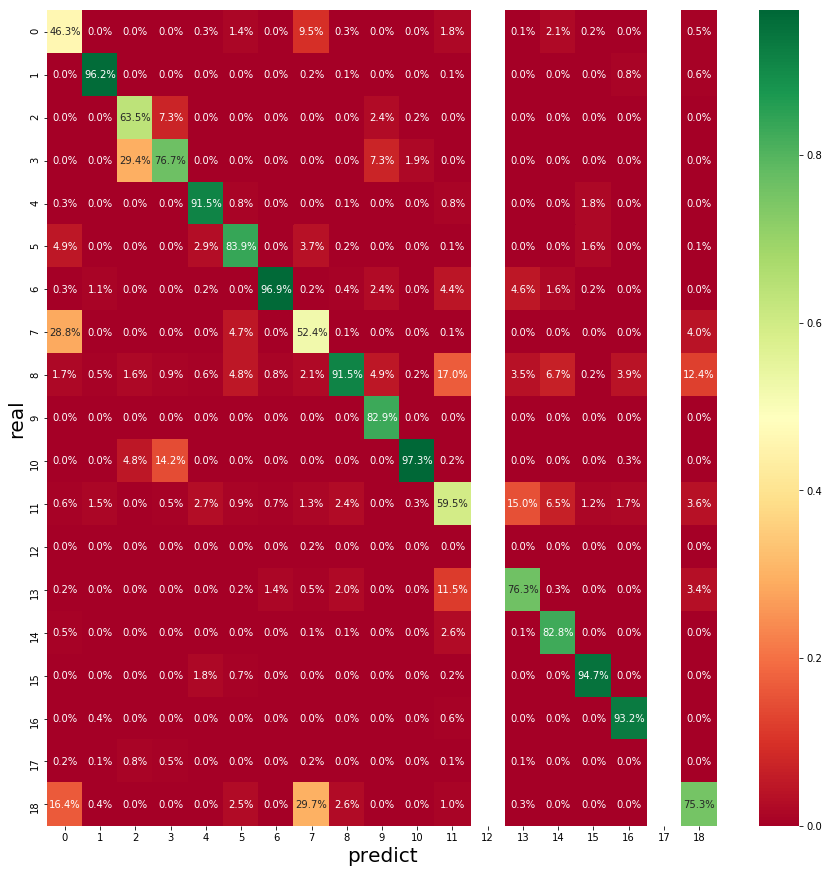

In [27]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [28]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 255, min_child_samples = 40,
                            max_depth = 8, learning_rate = 0.1,
                            lambda_l2 = 3, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [29]:
lgbm_c.fit(train_X, train_y, eval_set = [(train_X, train_y)],eval_names= 'valid', 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.291861
[200]	valid's multi_logloss: 0.240594
[300]	valid's multi_logloss: 0.206518
[400]	valid's multi_logloss: 0.182152
[500]	valid's multi_logloss: 0.164247
[600]	valid's multi_logloss: 0.151498
[700]	valid's multi_logloss: 0.142165
[800]	valid's multi_logloss: 0.134511
[900]	valid's multi_logloss: 0.128598
[1000]	valid's multi_logloss: 0.123936
[1100]	valid's multi_logloss: 0.120994
[1200]	valid's multi_logloss: 0.119293
[1300]	valid's multi_logloss: 0.117423
[1400]	valid's multi_logloss: 0.116727
[1500]	valid's multi_logloss: 0.116727
[1600]	valid's multi_logloss: 0.116727
[1700]	valid's multi_logloss: 0.116727
[1800]	valid's multi_logloss: 0.116727
[1900]	valid's multi_logloss: 0.116727
[2000]	valid's multi_logloss: 0.116727
Did not meet early stopping. Best iteration is:
[1646]	valid's multi_logloss: 0.116727


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=9, lambda_l2=3,
               learning_rate=0.1, max_depth=8, min_child_samples=40,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=255, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [30]:
f_train_y_pred = lgbm_c.predict_proba(train_X)

In [31]:
y_pred = lgbm_c.predict_proba(test_X)

In [32]:
y_pred

array([[4.92720799e-05, 1.08784844e-04, 5.20466946e-04, ...,
        3.83521274e-04, 1.97555831e-03, 7.43149253e-05],
       [1.52910899e-04, 2.34202933e-04, 4.57524529e-05, ...,
        6.04394150e-05, 8.79055930e-04, 2.68408150e-04],
       [1.10731826e-05, 4.45790067e-06, 1.86199397e-06, ...,
        3.39153096e-06, 2.38482480e-05, 6.61923587e-06],
       ...,
       [3.47849017e-06, 2.71526042e-06, 2.44532548e-07, ...,
        6.93558507e-07, 5.93341782e-07, 8.15344327e-05],
       [3.99969281e-06, 9.48537051e-06, 4.43449878e-07, ...,
        8.12932928e-07, 1.13777523e-06, 8.13570423e-05],
       [1.70986345e-04, 3.73465749e-06, 1.88055584e-06, ...,
        4.85105027e-06, 4.29976410e-06, 8.31801122e-06]])

In [33]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)